# **IMPORTS**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv

In [2]:
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import torch.utils.data as utils

In [5]:
import random

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [8]:
from PIL import Image

In [9]:
import timm

In [10]:
import gc

# **DATASET LOADING**

In [11]:
close_dir = "/kaggle/input/mrl-eye-dataset/mrleyedataset/Close-Eyes"
open_dir = "/kaggle/input/mrl-eye-dataset/mrleyedataset/Open-Eyes"

In [12]:
close_paths = []
open_paths = []

In [13]:
for dirname, _, filenames in os.walk(open_dir):
        for filename in filenames:
            open_paths.append(os.path.join(dirname, filename))

In [14]:
for dirname, _, filenames in os.walk(close_dir):
        for filename in filenames:
            close_paths.append(os.path.join(dirname, filename))

In [15]:
print(len(open_paths))

42952


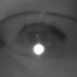

In [16]:
Image.open(open_paths[0])

In [17]:
print(len(close_paths))

41946


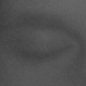

In [18]:
Image.open(close_paths[0])

So the dataset is pretty balanced so mostly there will be no issue of model biasness.

Now I will make a pandas dataframe where I will store these paths along with there labels. Labels that I thought are 0 for closed eye images and 1 for open eye images.

In [19]:
paths = []
labels = []

In [20]:
for i in range(len(open_paths)):
    paths.append(open_paths[i])
    labels.append(1)

In [21]:
for i in range(len(close_paths)):
    paths.append(close_paths[i])
    labels.append(0)

In [22]:
print(len(paths), len(labels))

84898 84898


Now there is one issue that our labels list contains 1's in the starting and 0's in the end this will create issue when we will do train-test split further as model will not get enough datapoints so to avoid that let's shuffle it once right now

In [23]:
combined = list(zip(paths, labels))

random.shuffle(combined)

paths[:], labels[:] = zip(*combined)

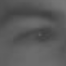

In [24]:
Image.open(paths[590])

In [25]:
labels[590]

1

Shuffled successfully

In [26]:
df = pd.DataFrame({'paths': paths, 'labels': labels})

In [27]:
df.to_csv('DrowsinessDataset.csv', index=False)

In [28]:
df.head()

,paths,labels
0,/kaggle/input/mrl-eye-dataset/mrleyedataset/Op...,1
1,/kaggle/input/mrl-eye-dataset/mrleyedataset/Op...,1
2,/kaggle/input/mrl-eye-dataset/mrleyedataset/Op...,1
3,/kaggle/input/mrl-eye-dataset/mrleyedataset/Cl...,0
4,/kaggle/input/mrl-eye-dataset/mrleyedataset/Op...,1


# **Data Processing and Pre-processing of images**

In [30]:
image = cv.imread(df.iloc[590]['paths'])
if image is not None:
    height, width, channels = image.shape
    print(f"Image shape: Height={height}, Width={width}, Channels={channels}")
else:
    print("Error: Image not loaded correctly")

Image shape: Height=66, Width=66, Channels=3


In [31]:
class EyeDataset(Dataset):
    
    def __init__(self, data, augmentations=None):
        self.paths = data['paths']
        self.labels = data['labels']
        if augmentations is None:
          self.augmentations = transforms.Compose([transforms.ToTensor()])

        else:
          self.augmentations = augmentations
    
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        label = self.labels[index]

        sample = Image.open(self.paths[index]).convert("RGB")
        sample = self.augmentations(sample)

        return sample,label

In [32]:
augmentations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [33]:
eye_dataset = EyeDataset(df, augmentations)

In [34]:
sample, label = eye_dataset[90]

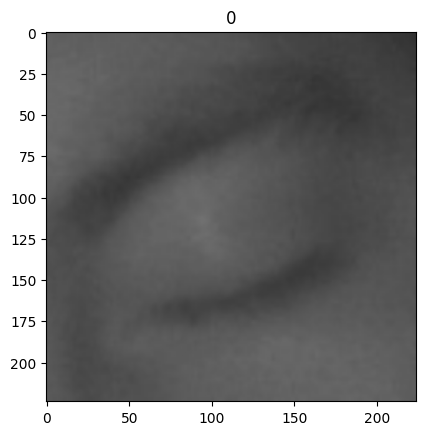

In [35]:
image = sample.numpy().transpose((1, 2, 0))  

image = np.clip(image, 0, 1)

plt.imshow(image)
plt.title(label)
plt.show()

Wooho the dataset is ready!! Time to split it into training and testing datasets and create dataloaders!!

In [36]:
train_indices, testing_indices = train_test_split(range(len(eye_dataset)), test_size=0.2, random_state=42)

In [37]:
train_dataset = utils.Subset(eye_dataset, train_indices)
testing_dataset = utils.Subset(eye_dataset, testing_indices)

In [38]:
print(f"Length of training dataset:{len(train_dataset)}")
print(f"Length of testing dataset:{len(testing_dataset)}")

Length of training dataset:67918
Length of testing dataset:16980


In [39]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=0)
test_loader = DataLoader(testing_dataset, shuffle=False, batch_size=32, num_workers=0)

# **MODEL CREATION**

I am using the pre-trained Xception model for this task. Using pre-trained model will help us leverage the advantages of transfer learning

In [41]:
model = timm.create_model("xception", pretrained=True)

In [42]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)

In [43]:
print(model)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

# **TRAINING**

In [49]:
class Config:
    learning_rate = 1e-4
    epochs = 10

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
class Trainer:
    def __init__(self, model, dataloaders, Config, device):
        self.device = device
        self.Config = Config
        self.model = model.to(self.device)
        self.train, self.test = dataloaders
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.Config.learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()
        
    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, 1) 
        return (preds == labels).sum().item() / labels.shape[0]

    def train_one_epoch(self):
        running_loss = 0
        running_acc = 0

        for X, y in self.train:
            X = X.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)  

            self.optim.zero_grad()
            outputs = self.model(X)

            loss = self.loss_fn(outputs, y)
            loss.backward()
            self.optim.step()

            running_loss += loss.item()
            running_acc += self.accuracy(outputs, y)

            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()

        train_loss = running_loss / len(self.train)
        train_acc = running_acc / len(self.train)

        return train_loss, train_acc

    def fit(self):
        losses = []
        accuracies = []


        for epoch in range(self.Config.epochs):
            self.model.train()
            train_loss, train_acc = self.train_one_epoch()
            losses.append(train_loss)
            accuracies.append(train_acc)
            print(f"EPOCH {epoch+1}/{self.Config.epochs}")
            print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}\n\n")

    @torch.no_grad()
    def inference(self):
        self.model.eval()
        running_acc = 0

        for X, y in self.test:
            X = X.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)  
            outputs = self.model(X)
            running_acc += self.accuracy(outputs, y)

            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()

        accuracy = (running_acc / len(self.test)) * 100
        return accuracy

    def predict(self, input_image):
        self.model.eval()
        input_image = input_image.to(self.device, torch.float)
        output = self.model(input_image)
        prediction = torch.sigmoid(output).item()

        return prediction

This was trained in Google colab using GPU i don't know why i was not able to use the accelerator here. I will load the model i trained here no problem :)

It was trained for 5 epochs and after 5 epochs the loss was 0.008814311389534963  and the training accuracy was 99.67763777673104!!  Pretty good haan :)

# **TESTING**

In [47]:
model.load_state_dict(torch.load('/kaggle/input/drowsy-model/pytorch/drowsy-model/1/Drowsymodel.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [50]:
trainer = Trainer(model, (train_loader, test_loader), Config, device)

In [ ]:
trainer.inference()

This has also been calculated in Google Colab and came out to be 99.1% accurate!!

In [66]:
image_path = '/kaggle/input/mrl-eye-dataset/mrleyedataset/Close-Eyes/s0001_00004_0_0_0_0_0_01.png'
image = Image.open(image_path).convert("RGB")
input_data = augmentations(image).unsqueeze(0).to(device)

In [67]:
with torch.no_grad():
    output = model(input_data)

probabilities = torch.softmax(output, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

In [68]:
print(predicted_class)

0


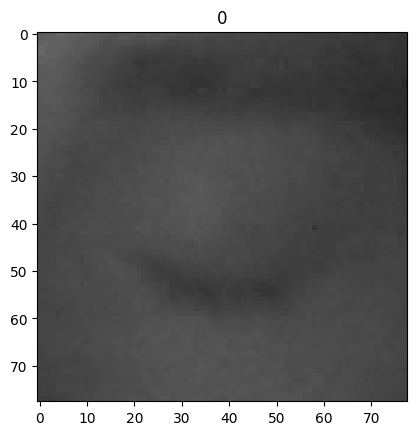

In [69]:
plt.imshow(image, cmap='gray')
plt.title(label)
plt.show()

# **WOOHO THE MODEL IS READY!!**